# <font color=blue>Scraping Mechanics- Extracting Web Data</font>

This notebook provides a comprehensive guide to scraping different types of web pages with a nod towards reproducible research principles.  The actions are separated into:

1.) __Harvesting__ - saving complete webpages (html or json code), 

2.) __Parsing__ - extracting the pieces of information you need, and

3.) __Testing__ - verifying whether the objects you save and extract remain accurate over time.

We do not treat each action as consecutive steps.  Instead,  we typically develop and run each action in parallel.  Since website content does not remain static over time and scrapers can take days if not months to collect data, it is imperative to continuously check whether you are collecting the right data and modify your code accordingly.  This documents provides guidance on how to both construct and maintain your code to scrape data seamlessly on the Kellogg Linux Cluster (KLC).

<font color=red>__*Please note that you must confirm you have authorization to scrape a website when working on KLC. This notebook uses toy examples to demonstrate scraping techniques and should not serve as justification to scrape data from any of these sources.*__</font>

# Run on KLC

If you'd like to launch this notebook and the code on KLC, first clone the contents of our github repo to your space on KLC.  

```
git clone https://github.com/rs-kellogg/Research_the_Right_Way
```


Then from the command line, get into the scraping subfolder

```
cd scraping
```

Type the following ONLY ONCE to create a conda environment.

```
source /kellogg/admin/bin/scrape.sh

```

This will take a while to run but creates the conda environment we use for these examples.  The following activates this enviroment and loads the jupyter notebook: 

```
source activate scrape_env
jupyter notebook --browser=chrome
````

# Table of Contents


1. [Web Scraping 101 - with requests and Beautiful Soup](#Basics)
    1. [Inspect the webpage](#basics1)
    2. [Save webpage contents](#basics2)
    3. [Extract data from saved files](#basics3)
    4. [Scaling Up - Sample Python Files](#basics4)
    
    
2. [Harvesting Strategies](#Harvest)
    1. [Basics](#Simple)
        1. [Sleep Times](#simple1)
        2. [Time Outs](#simple2)
        3. [Exception Handling](#simple3)
       
    2. [Keeping Logs](#Logs)
        1. [Errors Logs - status codes, file storage](#log1)
        2. [Data Sanity Checks](#log2)
        3. [Progress Files for easy Restarts/Retries](#log3)
        4. [Aborting after Consecutive Errors](#log4)

    3. [Strategies with Selenium](#Selenium)
        1. [Installing Web Drivers](#sel1)
        2. [Saving Json code not HTML](#sel2)
        3. [Button Clicks](#sel3)
        4. [Infinitely Loading Pages](#sel4)
  
  
3. [Parsing Strategies](#Extract)
    1. [Beautiful Soup extracts faster than Selenium](#extract1)
    2. [Find Robust Methods to Extract html Elements](#extract2)
    3. [HTML Encoding vs. Regex](#extract3)
    4. [Launch Parser in Parallel with Page Downloads](#extract4)
    
    
4. [Summary](#Rep)
    1. [Version Control - Setup Conda Environment](#rep1)
    2. [Automate Code Launches, Killswitches, Notification Emails](#rep2)
    3. [Modular Code - Making Testing Easier](#rep3)

# <font color=blue> Section 1- Web Scraping 101 </font> <a name="Basics"></a>
In order to scrape a webpage, it is important to first look over the page for the content you need. Thereafter, we normally develop separate code that (1) saves the webpage contents, and (2) extract the data. __We try our best to run these actions in parallel, as opposed to waiting for one to fully complete before launching the other.__ We separate the code into distinct pieces to ensure each step of our scraping project is modular and can be easily tested, debugged, and repaired over time.  As your code collects and extracts data, continuously testing your output at each step will ensure you do not accidentally collect garbage data and need to rerun your scraper. 

This section first shows you how to explore the html or json code for tags, attributes, and values that contain data. You will:

(a) explore the page, 

(b) save the html code, and 

(c) parse the code for the information you need. 

After covering the basics, the subsequent sections will improve these actions by exploring methods to test the pages and data collected over time. We will also address how to solve common issues, and make your work easily reproducible.

### <font color=green>Step A: Inspect the webpage <a name="basics1"></a></font>

First let's take a closer look at the webpages we are scraping.  For instance, we can look at Amazon's page on the Yahoo Finance website:
https://finance.yahoo.com/quote/AMZN/

In a Chrome Browser, we highlight the element we want (an article's weblink), right click, and select __Inspect Element__ or __Inspect__.

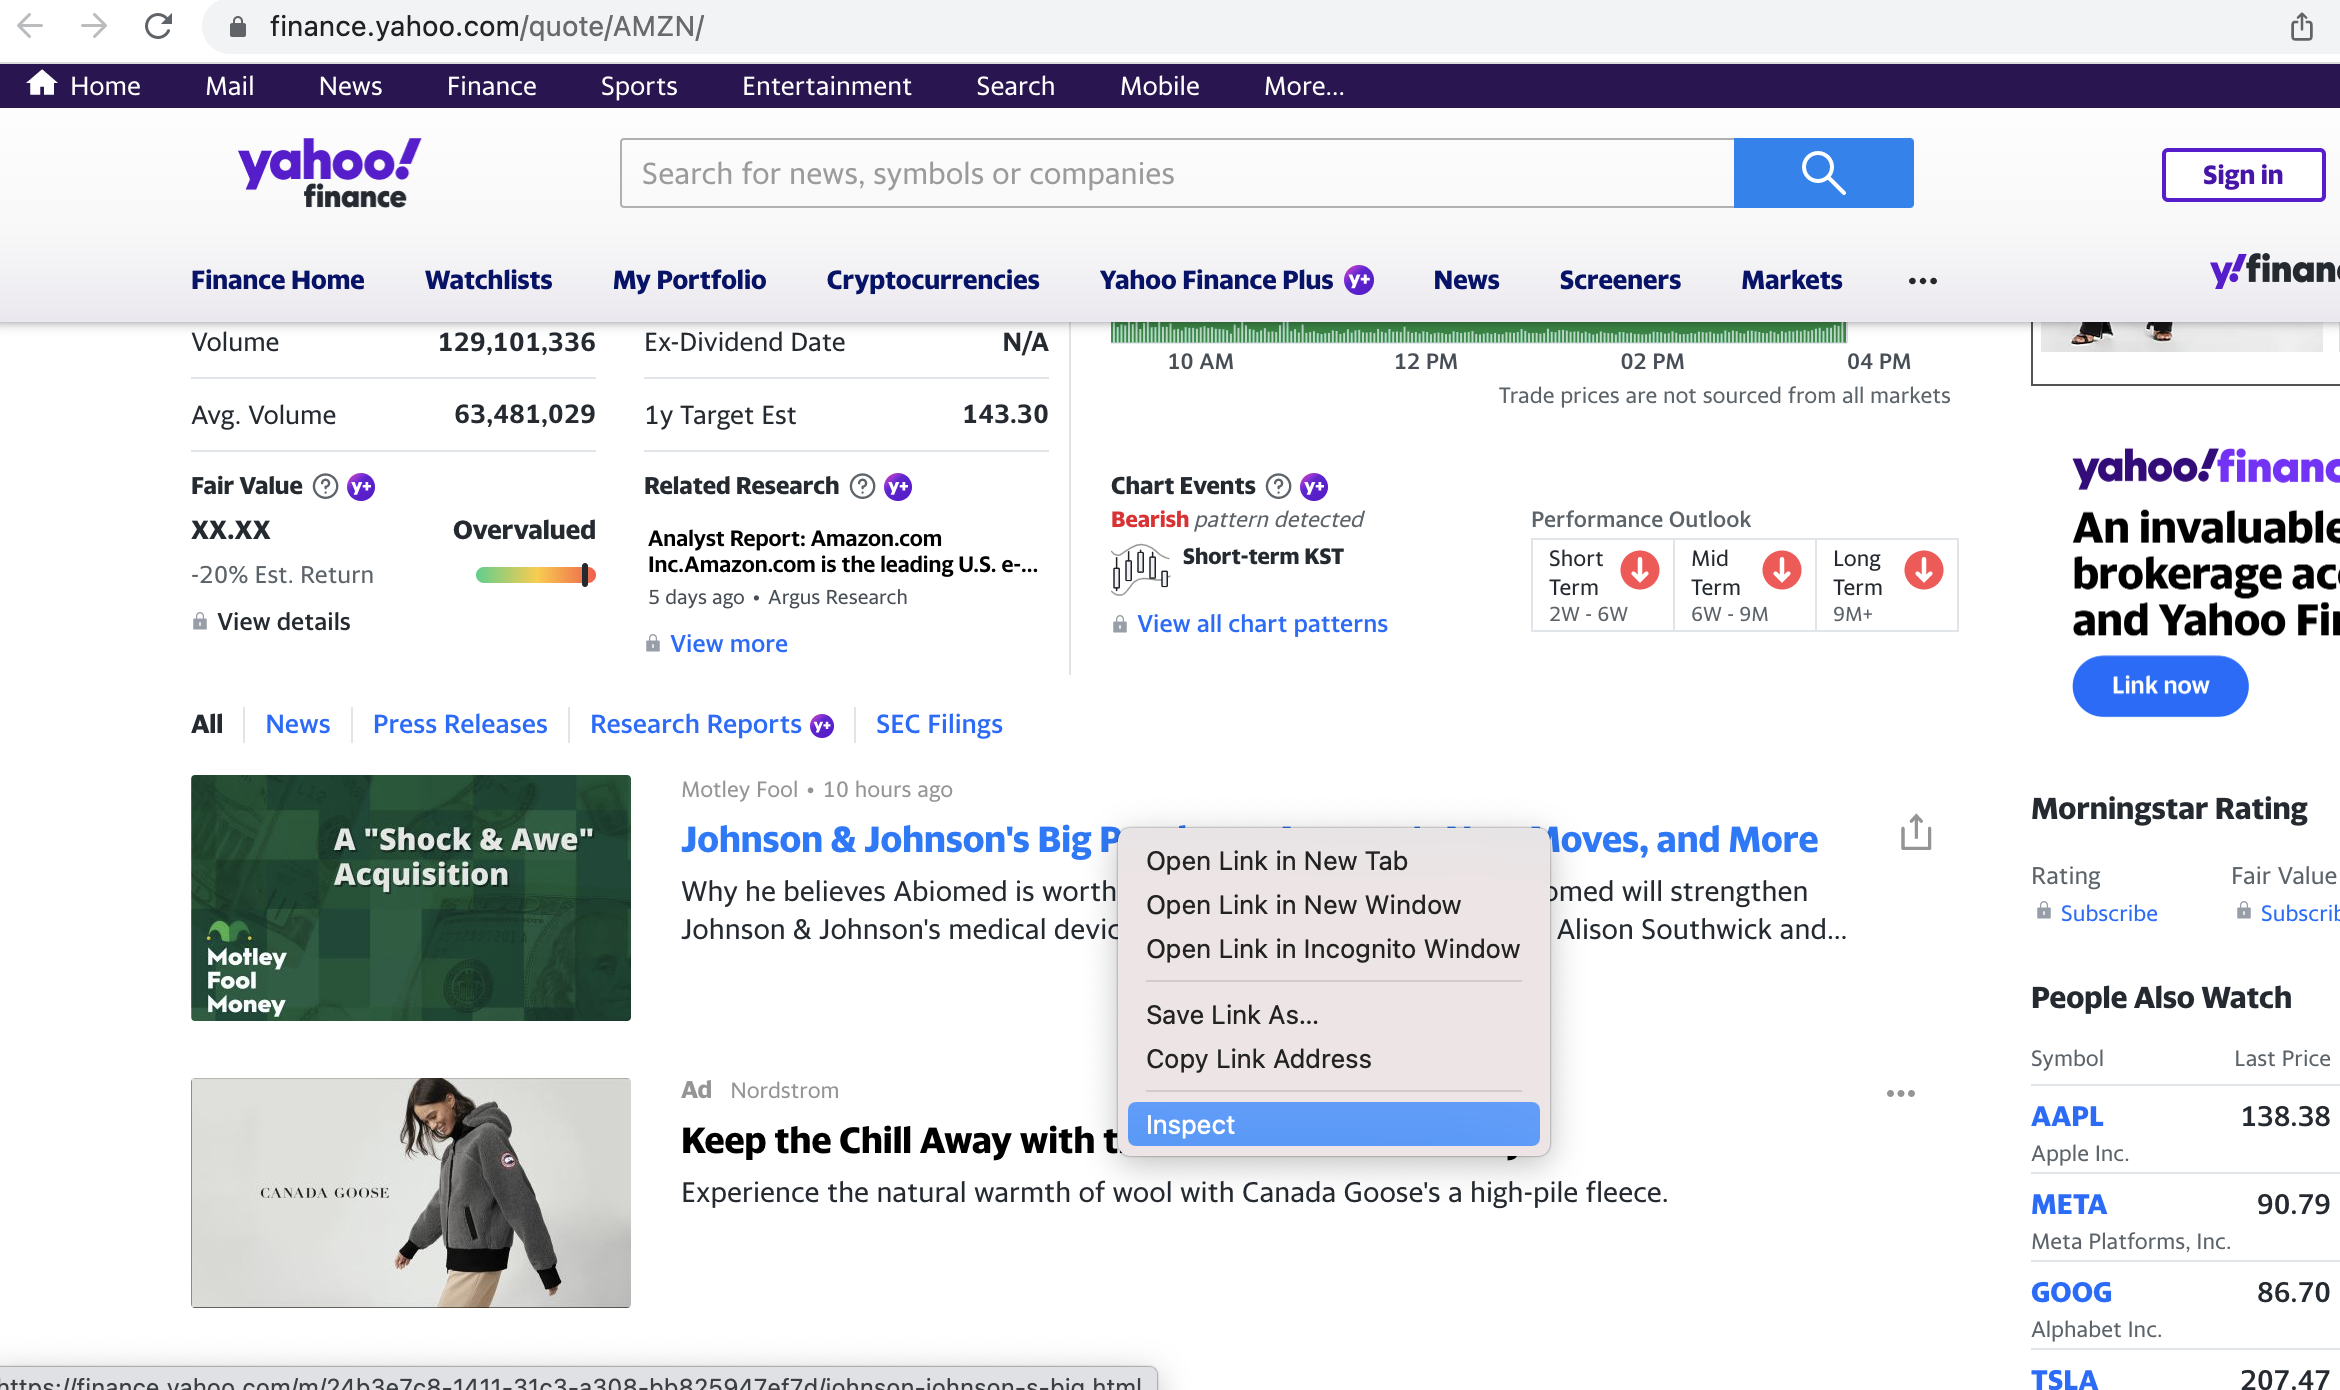

In [1]:
import os
cwd = os.getcwd()
from IPython.display import Image
Image(filename= cwd + "/figures/image1.png", width=5000, height=5000)

This will take you to Chrome's Developer Tools where you can inspect the html __tags__ and __attributes__ of the element you highlighted.

As a quick primer, html code is typically setup as follows:

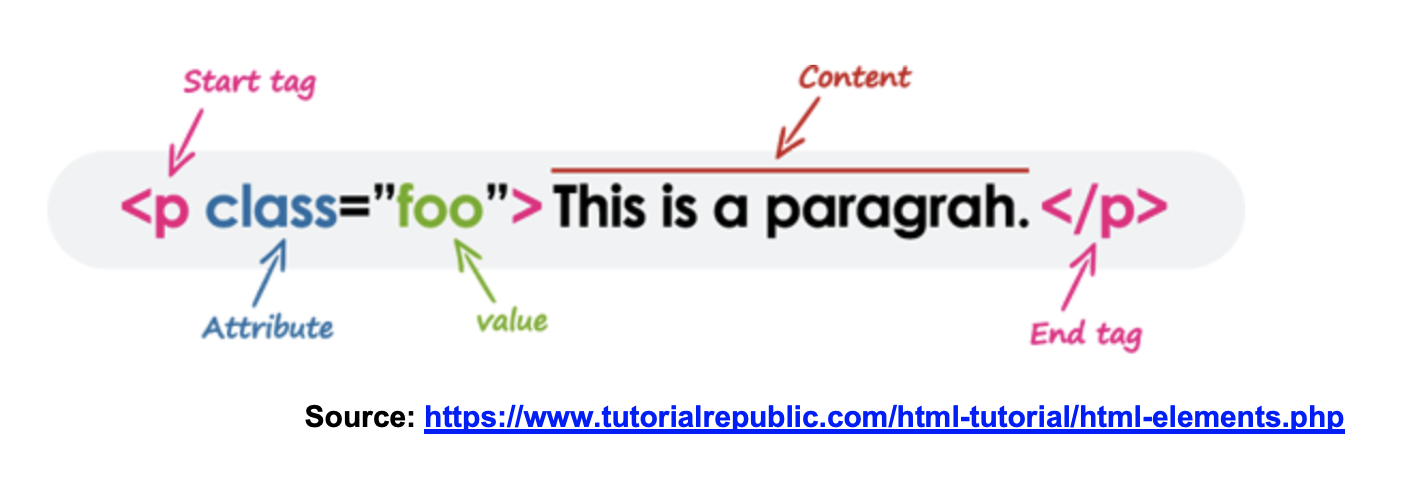

In [2]:
from IPython.display import Image
Image(filename= cwd + "/figures/image2.png", width=5000, height=5000)

In the Developer Tools, you can see that first article's webpage ("/m/24b3e7c8-1411-31c3-a308-bb825947ef7d/johnson-johnson-s-big.html") can be found within the __href__ attribute of the __&lt;a>__ tag. 

The __&lt;a>__ tag is actually a 'child' tag to the 'parent' __&lt;h3>__ tag with an __id__ attribute and a "Mb(5px)" value.

Note that if you use your mouse to hover over an html tag, it will highlight that element on the webpage. 

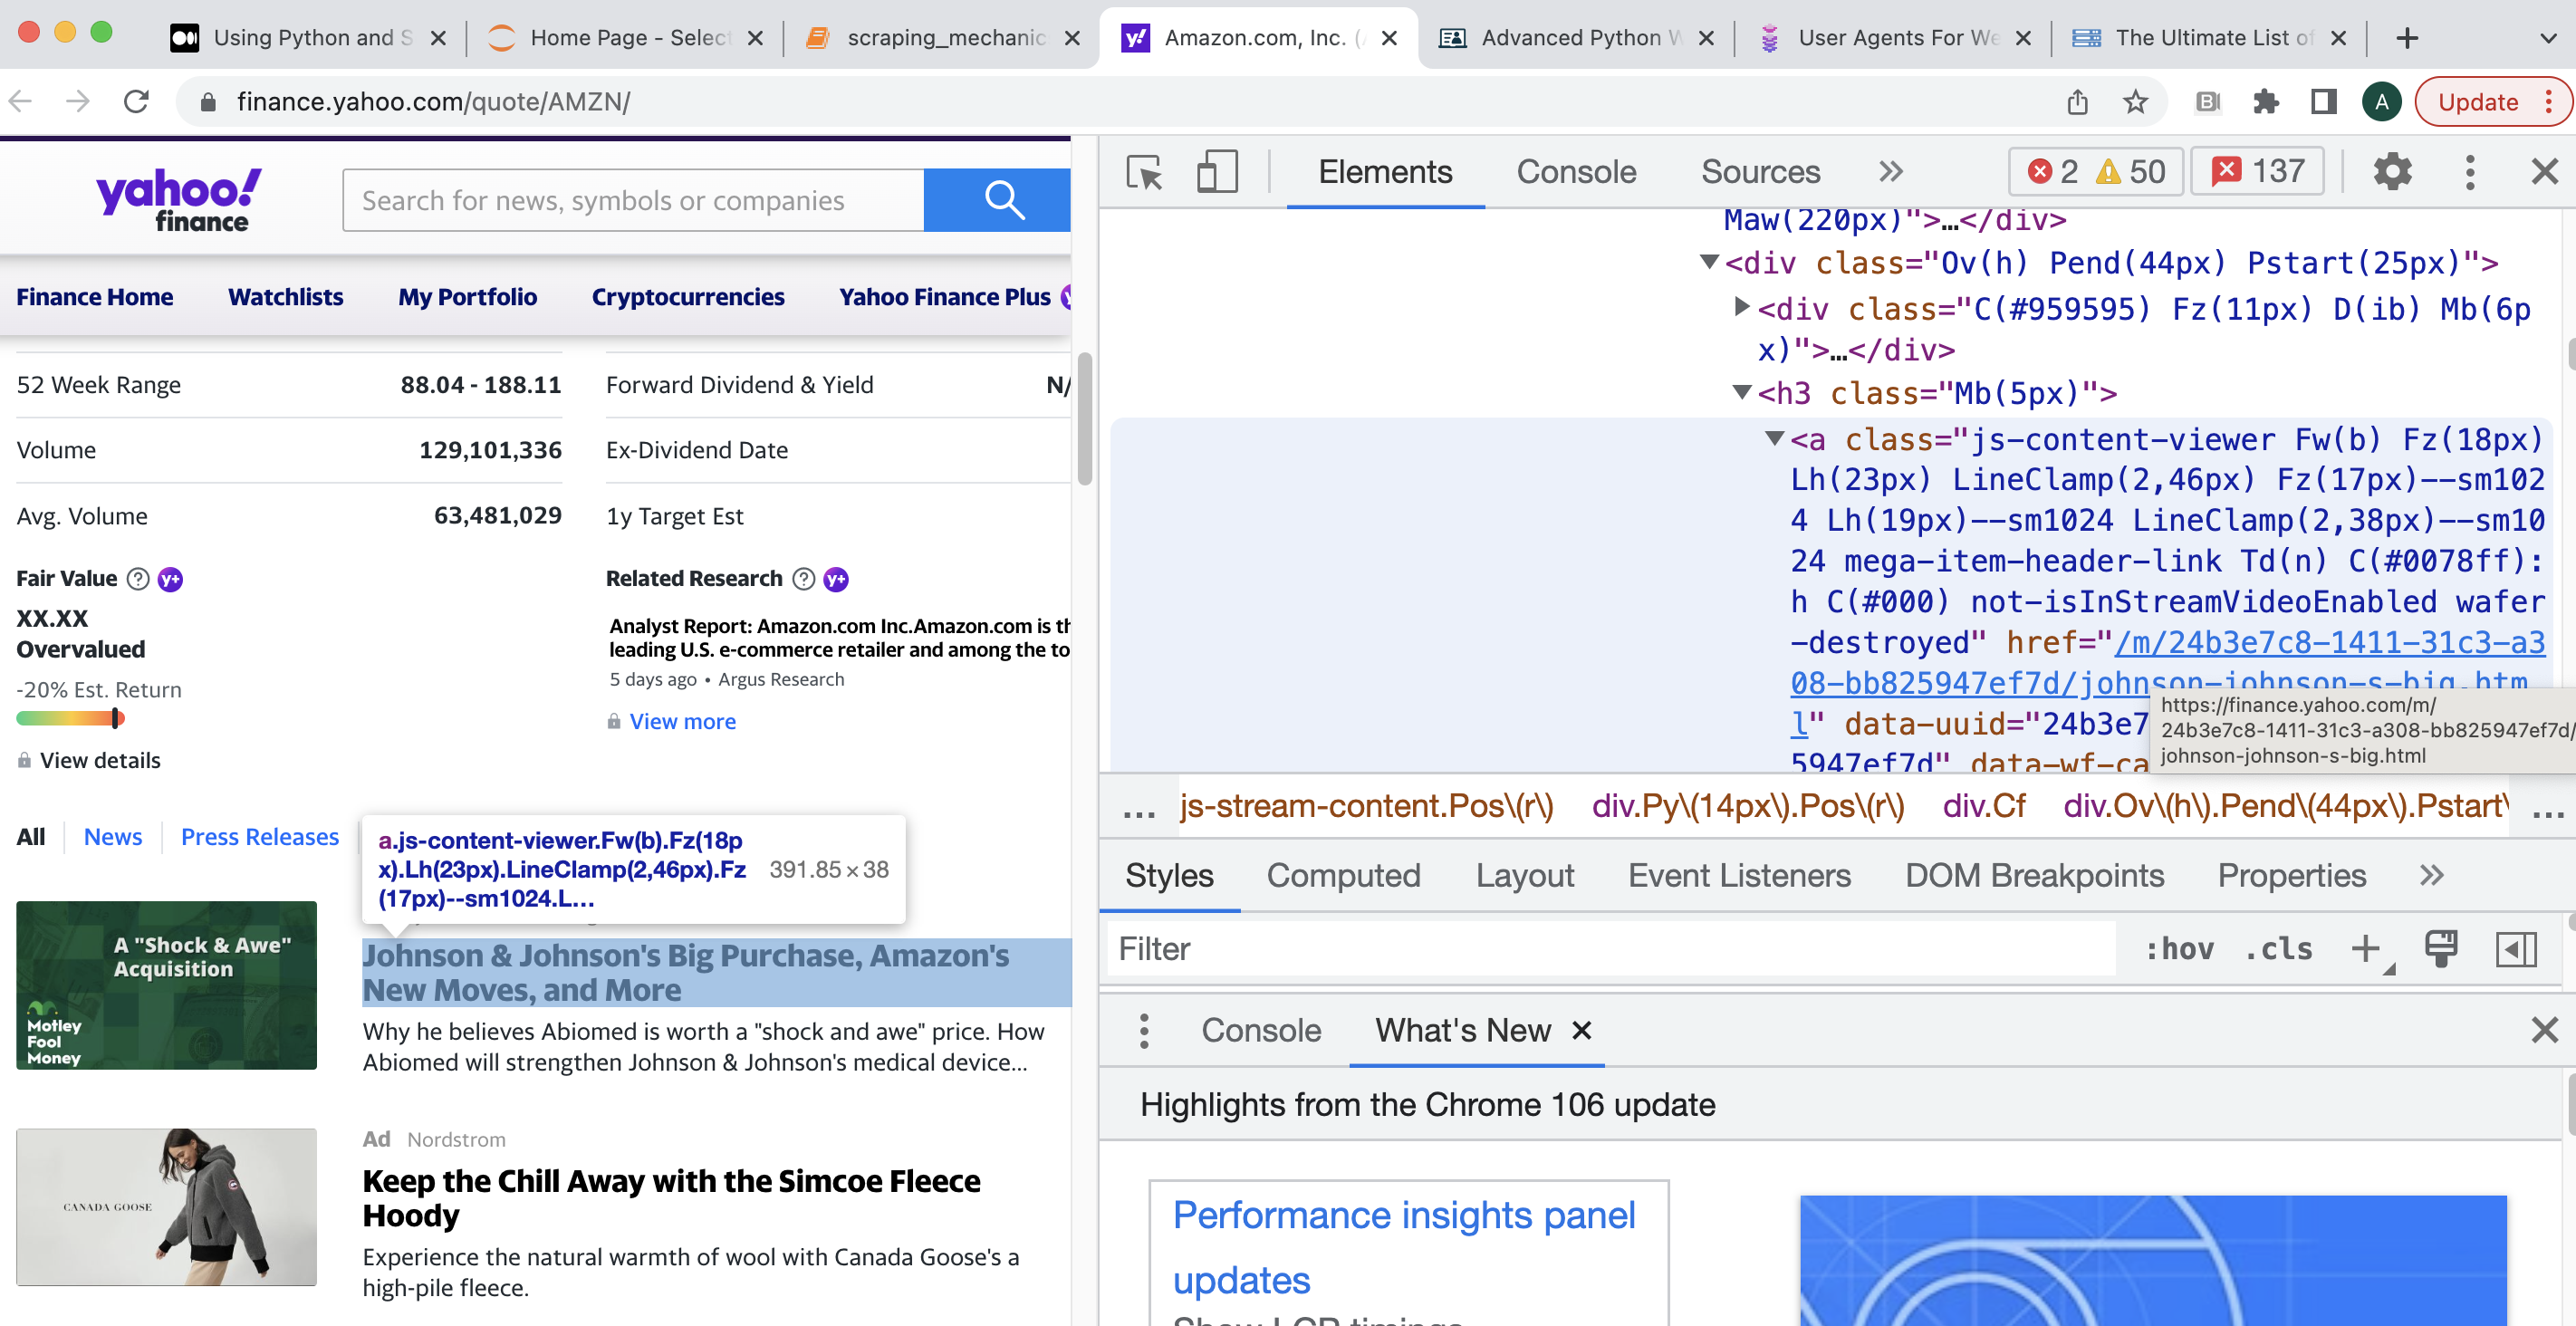

In [3]:
from IPython.display import Image
Image(filename= cwd + "/figures/image3.png", width=5000, height=5000)

To see the HTML table that contains information for all Amazon articles, we can follow the same steps. The table falls under the __id__ attribute of the __&lt;div>__ tag. 

For more information on understanding the HTML code, see: https://www.tutorialrepublic.com/html-tutorial/




### <font color=green>Step B: Save webpage contents <a name="basics2"></a></font>

Since webpages are not static and can change constantly, it is useful to first save the raw html code of a webpage and later extract the data from a saved document.

We can use the _requests_ package in Python to automate this first step.

In [4]:
import requests
url = "https://finance.yahoo.com/quote/AMZN/"
page = requests.get(url)
with open('amazon.html', 'wb+') as f:
    f.write(page.content)

### <font color=green>Step C: Extract data from Saved Files<a name="basics3"></a></font>

Now let's transfer the contents of the saved html file to a __soup__ object that _Beautiful Soup_ can use for parsing. 

In [5]:
# open an html file and save to a soup object
import bs4 as bs
with open("amazon.html") as fp:
    soup = bs.BeautifulSoup(fp, 'html.parser')
str(soup)[1:500] # prints the first 500 characters

'!DOCTYPE html>\n<html class="NoJs chrome desktop failsafe" data-color-theme="light" id="atomic" lang="en-US"><head prefix="og: https://ogp.me/ns#"><script>window.performance && window.performance.mark && window.performance.mark(\'PageStart\');</script><meta charset="utf-8"/><title>Amazon.com, Inc. (AMZN) Stock Price, News, Quote &amp; History - Yahoo Finance</title><meta content="AMZN, Amazon.com, Inc., AMZN stock chart, Amazon.com, Inc. stock chart, stock chart, stocks, quotes, finance" name="key'

We can apply what we learned from inspecting the webpage and use the __find__ method in _Beautiful Soup_ to identify elements in html tags. Using the tags, attributes, and values, we idenfified for the HTML table and the article webpages, we can save this data to objects. 

In [6]:
# find the html table with the press releases
press = soup.find('div',{'id':"quoteNewsStream-0-Stream"})
articles = press.findAll('div',{'class':"Cf"})

Here are the attributes of the article table.

In [7]:
print(press.attrs)

{'id': 'quoteNewsStream-0-Stream', 'class': ['tdv2-applet-stream', 'Bdc(#e2e2e6)', 'Pos(r)', 'Z(1)'], 'style': 'max-width:900px'}


We can also drill down and inspect the first item in the article list.

In [8]:
print(str(articles[0])[0:100]) # print the first 100 characters
print(str(articles[0].attrs))

<div class="Cf"><div class="Fl(start) Pos(r) Mt(2px) W(26.5%) Maw(220px)"><div class="H(0) Ov(h) Bdr
{'class': ['Cf']}


The code below extracts the webpage for the first article.

In [9]:
# extract the website for the first press release
title = articles[0].find('h3', {'class': 'Mb(5px)'})
website = title.find('a', href=True)
website = website['href']
print(website)

/news/twitter-meta-lyft-and-more-another-wave-of-layoffs-hits-tech-182545675.html


Now we can save the first three article websites into a list object.

In [10]:
article_names = []
article_sites = []

for i in articles[0:3]:
    try:
        title = i.find('h3', {'class': 'Mb(5px)'})
        print(title.text)
        article_names.append(title.text)
        
        website = title.find('a', href=True)
        website = website['href']
        website = 'https://finance.yahoo.com' + str(website)
        print(website)
        article_sites.append(website)
        
    except:
        print("Skip Ads")


Twitter, Meta, Lyft, and more: Another wave of layoffs hits tech
https://finance.yahoo.com/news/twitter-meta-lyft-and-more-another-wave-of-layoffs-hits-tech-182545675.html
News Corp Says Lower Book Sales on Amazon, Foreign Exchange Weigh on Results
https://finance.yahoo.com/m/d2d4f81e-bc70-35ba-a374-ee57af7f709e/news-corp-says-lower-book.html
Netflix is interested in carrying live sports: report
https://finance.yahoo.com/m/4aead442-984d-3e3f-98d1-c84b15e998de/netflix-is-interested-in.html


We can also save the results to a pandas dataframe.

In [11]:
import pandas as pd

article_list = pd.DataFrame(
    {'title': article_names,
     'website': article_sites,
    })

article_list

,title,website
0,"Twitter, Meta, Lyft, and more: Another wave of...",https://finance.yahoo.com/news/twitter-meta-ly...
1,"News Corp Says Lower Book Sales on Amazon, For...",https://finance.yahoo.com/m/d2d4f81e-bc70-35ba...
2,Netflix is interested in carrying live sports:...,https://finance.yahoo.com/m/4aead442-984d-3e3f...


Finally, we can export the results to a csv file.

In [12]:
import csv
with open('amazon_press_pages.csv', "w") as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for site in article_sites:
        wr.writerow([site])

### <font color=green>Step D: Scaling Up - Sample Python Files <a name="basics4"></a></font>

The following files are also available to download from our github repo here: https://github.com/rs-kellogg/Research_the_Right_Way

1.) __tickers.txt__ - a text file containing thousands of ticker symbols you can use to assemble yahoo finance urls to download

2.) __harvester_helper.py__ and __parser_helper.py__ - files that contain mostly generic python functions you can use when dowloading webpages and extracting web page data, respectively, 

3.) __yahoo_harvester.py__ - code that downloads yahoo finance webpages for each ticker symbol in the input text file. 

4.) __yahoo_parser.py__ - code that extracts and saves the press release article names and websites from each saved yahoo finance webpage.

These files will be used to demonstrate more detailed examples of some of the concepts we will cover in subsequent sections. 


# <font color=blue> Section 2 - Harvesting Strategies </font> <a name="Harvest"></a>

Since most webpages are not static, employing a two-step approach of first saving the raw contents (html or json code) of webpages and parsing later enables us to:

(1) save evidence of what the webpage looked like on the day we scraped;

(2) scrape faster by saving pages and troubleshooting extraction issues in parallel;

(3) revisit the source code to extract additional content later.

This section highlights best practices and some techniques you can employ to simplify accessing and saving web pages.  

### <font color=green>(A) Basics<a name="Simple"></a></font>
Before we delve into more complex strategies, we'll discuss incorporating some basic actions like __sleep times__, __time outs__, and __exception handling__ in your page requests

#### <font color=green>(a) Sleep Times<a name="simple1"></a></font>
When scraping websites, it's important to throttle our requests by employing sleep times between opening new webpages.  This step prevents us from burdening websites with too many frequent requests that might resemble a bot attack. By employing sleep times, we ensure that we neither overwhelm a website's server, nor get blocked.  

Here is a sleep time example.

In [100]:
import time
t = time.time()
time.sleep(10)
response = requests.get(url)
print("At " + time.strftime("%X") + " the page was sucssefully downloaded.")
print("This much time elapsed: " + '%.3f'%(time.time() - t) + " in seconds.")

At 09:54:08 the page was sucssefully downloaded.
This much time elapsed: 10.208 in seconds.


#### <font color=green>(b) Time Outs<a name="simple2"></a></font>
Conversely, we can also apply a time-out feature to our website request.  This does not throttle the request, but rather triggers a "Timeout Exception" if the website cannot be reached within a specified number of seconds. 

In [101]:
import time
t = time.time()
response = requests.get(url, timeout=10)
print("At " + time.strftime("%X") + " the page was sucssefully downloaded.")
print("This much time elapsed: " + '%.3f'%(time.time() - t) + " in seconds.")

At 09:54:38 the page was sucssefully downloaded.
This much time elapsed: 0.161 in seconds.


Notice that the sleep time actually delayed our get requests by 10 seconds. However, the timeout request did not delay our website call. Since these two features perform different actions, you should consider using both in your scraper. 

#### <font color=green>(c) Exception Handling<a name="simple3"></a></font>
We could also place the page request within a try-except block to keep track of any pages that fail to load. 

In [102]:
try:
    time.sleep(10)
    response = requests.get(url, timeout=10)
    print("At " + time.strftime("%X") + " the page was sucssefully downloaded.")
except:
    print('Could not download page.')

At 09:55:27 the page was sucssefully downloaded.


Using these tools will allow us to develop more intricate methods of testing what we collect and aborting a process that stops working.

### <font color=green>(B) Keeping Logs <a name="Logs"></a></font>

This section shows you how to maintain informative logs that will make tracking your progress, testing your data, and enabling restarts/retries much easier.

#### <font color=green>(a) Logging Errors - status codes and file storage on KLC <a name="log1"></a></font>

In our Yahoo Finance example, we used print statements to track progress. We printed whether a file was successfully downloaded and the time it was saved.

There are a host of other issue that you might encounter when you are saving web pages to parse.  This section shows you how you can utilize exception handling to address __proxy server errors__ based on HTTP response codes and __file storage problems__ you might encounter on KLC. 

If we use a get method to access a webpage, our page request generates an HTTP status code. The figure below summarizes the number ranges for different status codes.

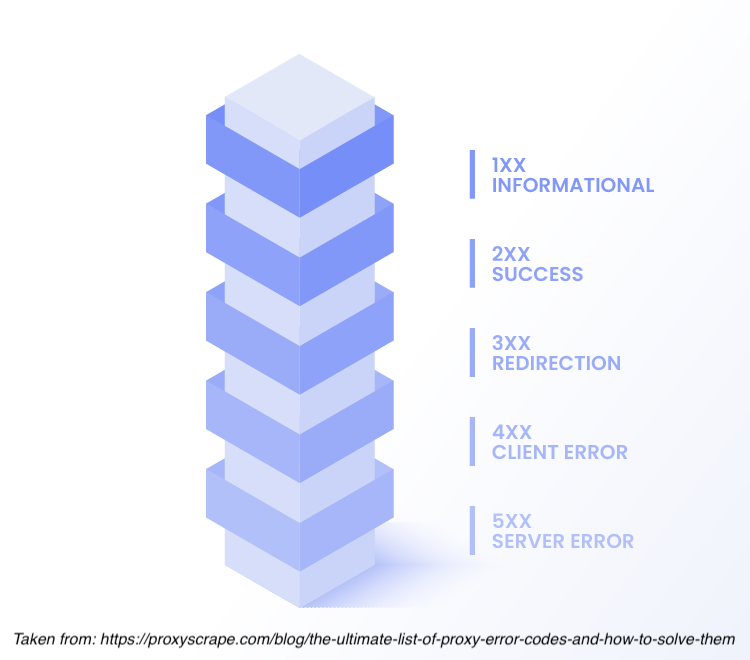

In [13]:
from IPython.display import Image
Image(filename= cwd + "/figures/status_codes.png", width=5000, height=5000)

A status code of:

- 200 indicates that a page was successfully reached. 
- 404 errors occur when a page is not found (possibly a bad url). 
- 429 errors return when you've made too many page requests (possibly when the website blocks you). 
- 500 errors occur when a website server is unavailable. 

You can access status codes from a get request.

In [103]:
url = "https://finance.yahoo.com/quote/AMZN/"
response = requests.get(url)
response.status_code

200

You can still save the html code of a webpage that produces some of these errors.  That's why it is useful to account for these issues by not only tracking HTTP codes as you save pages, but possibly including methods to refresh pages, buffer your requests, or abort your scraper when one of these errors are triggered.  In the example below, we attempt to successfully reach a page __three times__ before recording an error and aborting

In [111]:
attempt_counter = 0
while True:
    attempt_counter = attempt_counter + 1
    time.sleep(5)
    source = requests.get(url, timeout=10)
    if source.status_code == 200:
        print("Page successfully reached with status code 200.")
        break
    elif attempt_counter > 2:
        print("Page returned status code: " + str(source.status_code))
        print("Process aborted.")
        break

Page successfully reached with status code 200


In the Yahoo Finance python subdirectory, you'll find a __harvest_helper.py__ file that shows you to construct similar code for Selenium in the __get_status__ function and the __page_get_selenium__ function.

Another progress check is to verify that a new webpage file was successfully saved to your directory on KLC.

In [180]:
file_count = len(os.listdir(cwd))
print("Initially there were " + str(file_count) + " files saved.")
time.sleep(5)
source = requests.get(url, timeout=10)
with open('amazon.html', 'wb+') as f:
    f.write(source.content)
if len(os.listdir(cwd)) - file_count != 1:
    print("A new file was not saved.")
else:
    print("A file was successfully saved.")

Initially there were 20 files saved.
A file was successfully saved.


If a file storage error occurs on KLC, you might have run out of space in your home or project directory. 

#### <font color=green>(b) Sanity Checks <a name="log2"></a></font>

Although we recommend separating the harvesting (page downloads) from the parsing (data extraction) step when scraping, you might want to create __sanity checks__ to ensure a particular piece of information is found on each page you download. This could be as easy as extracting a data point from a webpage or checking whether a text string or html table exists on a page. Again, in the Yahoo Finance example, we can check if the press articles table exists.

In [110]:
url = "https://finance.yahoo.com/quote/AMZN/"
source = requests.get(url, timeout=10)
soup = bs.BeautifulSoup(source.text, 'html.parser')
try:
    press = soup.find('div',{'id':"quoteNewsStream-0-Stream"})
    articles = press.findAll('div',{'class':"Cf"})
    if len(articles) > 1:
        print("A table was found on the page.")
except:
    print("Page did not have a table.")

table was found


#### <font color=green>(c) Progress Files for easy Restarts/Retries <a name="log3"></a></font>

So far, we've used __print statements__ to track progress. Saving these print statements to a __log file__ might sufficiently keep track of progress for some projects.  Another method is to save different indicators to a __progress file__ that can be used to seemlessly restart your code later on.

If we start with an index of web pages to scrape, we can create a progress file with this list that we update as we successfully download pages. In the future, we can read in this progress file to determine where we left off and restart a scraper at that point.  This is especially useful if a scraper abruptly stops.

In the example below, we create a __progress file__ from a list of ticker symbols if the file does not already exist.  If we have an existing __progress file__, we use it to determine where to restart the scraper. 

In [192]:
import os
import pandas as pd
tickers = ['AMZN', 'AAPL', 'MSFT', 'FB', 'GOOG', 'A']

file_exists = os.path.isfile('progress.csv')
if not file_exists:
    url_stem = "https://finance.yahoo.com/quote/"
    urlList = [url_stem + s for s in tickers]
    codeList = [None] * len(urlList)
    progress = pd.DataFrame(list(zip(urlList,codeList)), columns =['URLs', 'Response_Codes'])
    progress.to_csv('progress.csv', index=False)
else:
    progress = pd.read_csv('progress.csv')
    run = progress[progress['Response_Codes'] != 200]
    urlList = run['URLs'].tolist()

for i in urlList:
    print(i)
    # save pages
    # append progress file with new status codes


https://finance.yahoo.com/quote/AMZN
https://finance.yahoo.com/quote/AAPL
https://finance.yahoo.com/quote/MSFT
https://finance.yahoo.com/quote/FB
https://finance.yahoo.com/quote/GOOG
https://finance.yahoo.com/quote/A


If we change one of the status codes to 200 and rerun the code above, you can see how a potential scraper would be easier to restart in the future if a service interruption on our server or the data source server caused your scraper to stop.

Again the __harvest_helpers.py__ file has functions for a __progress_file_maker__ and __progress_tracker__ that are deployed in the __yahoo_harvest.py__ to enable code restarts from where you left off based on the existence of a progress file. 

#### <font color=green>(d) Aborting after Consecutive Errors <a name="log4"></a></font>

The three potential errors we have checked in the Yahoo Finance pages example include (1) status code errors, (2) file storage issues, and (3) sanity checks to ensure the pages we save actually have the html objects we need to extract. The best advice we can offer is to be creative when coding other potential errors you can encounter.

In some cases, it might be alright to ignore these errors and continue harvesting webpages if they arise sparingly.  If these errors occur repeatedly, however, it could indicate that we are starting to collect useless data because a server has blocked us or the source code of a webpage has drastically changed.  In the case of consecutive errors, it might be more efficient to abort our scraper and revisit our code or website access.  The example below demonstrates how we can abort page downloads if we experience 4 consecutive status code errors. 

In [197]:
tickers = ['AMZN', 'AAPL', 'MSFT', 'FB', 'GOOG', 'A']
urlList = ["https://finance.yahoo.com/quote/" + s for s in tickers]

code_error_counter = 0

for i in urlList:
    print(i)
    time.sleep(5)
    response = requests.get(i, timeout=10)
    status_error = 1 if response.status_code != 200 else 0
    print(status_error)
    code_error_counter = (code_error_counter * status_error) + status_error
    if code_error_counter > 3:
        print("Stop scraper, too many consecutive errors.")
        break

https://finance.yahoo.com/quote/AMZN
0
https://finance.yahoo.com/quote/AAPL
0
https://finance.yahoo.com/quote/MSFT
0
https://finance.yahoo.com/quote/FB
1
https://finance.yahoo.com/quote/GOOG
0
https://finance.yahoo.com/quote/A
0


The same __harvest_helpers.py__ file also has a __error_killswitch_function__ that aborts the script after 4 consecutive errors occur.

### <font color=green>(B) Strategies with Selenium <a name="Selenium"></a></font>

This section outlines different issues you might encounter that will prevent you from easily accessing a web page's data with the _requests_ and _Beautiful Soup_ libraries alone. _Selenium_ comes in handy when a webpage is formated as json code instead of html, a page requires button clicks to access data, or a page has an infinitely loading scroll. 

In order to use _Selenium_, we'll first cover how to install it on KLC.

#### <font color=green>(a) Installing Web Drivers <a name="sel1"></a></font>

One of the most common issues with using _Selenium_ is finding the right driver version to run with your web browser.  Incompatability between the driver version and browser version will prevent you from running selenium. 

One way to resolve this issue is to let the python __ChromeDriverManager__ or __GeckoDriverManager__ packages download the appropriate driver for you on KLC.  The code below allows you to run _Selenium_ on KLC using a Chrome Browser

In [28]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import time

driver = webdriver.Chrome(ChromeDriverManager().install())
url = "https://finance.yahoo.com/quote/AMZN/"
driver.get(url)
time.sleep(10)

#driver.quit()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 107.0.5304
[WDM] - Get LATEST chromedriver version for 107.0.5304 google-chrome
[WDM] - About to download new driver from https://chromedriver.storage.googleapis.com/107.0.5304.62/chromedriver_mac64.zip
[WDM] - Driver has been saved in cache [/Users/ambreenchaudhri/.wdm/drivers/chromedriver/mac64/107.0.5304.62]


Likewise, you can use the __GeckoDriverManager__ to install the appropriate geckodriver to run _Selenium_ with Firefox on KLC

In [ ]:
from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager
import time

driver = webdriver.Firefox(executable_path=GeckoDriverManager().install())
url = "https://finance.yahoo.com/quote/AMZN/"
driver.get(url)
time.sleep(10)

driver.quit()

#### <font color=green>(b) Saving Json code not HTML <a name="sel2"></a></font>

Now, let's look at an example of a webpage that fails when we attempt to save the html code to a file.

In [1]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.vanguard.com.au/personal/products/en/overview'
response = requests.get(url, timeout=10)
soup = BeautifulSoup(response.content, 'html.parser')

try:
    table = soup.find('div',{'class':"vga-overview-serch-results"})
    headings = table.findAll('div',{'class':"vga-headings-content"})
    print(len(headings))
    for i in headings:
        print(i.text)
except:
    print("Table could not be found.")

Table could not be found.


If we inspect the webpage for Vanguard.com further, you'll see that there are a lot of __&lt;script>__ elements on the page that indicate the page is written with Javascript.

Since this page uses Javascript, we cannot reach it with the an attempt to capture the html code alone. Now, let's try saving and extracting the page's source code using _Selenium_ instead.  

In [211]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

driver = webdriver.Chrome(ChromeDriverManager().install())
url = 'https://www.vanguard.com.au/personal/products/en/overview'
driver.get(url)

soup = BeautifulSoup(driver.page_source, 'html.parser')

try:
    table = soup.find('div',{'class':"vga-overview-serch-results"})
    headings = table.findAll('div',{'class':"vga-headings-content"})
    print(len(headings))
    for i in headings:
        print(i.text)
except:
    print("Table could not be found.")

driver.close()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 107.0.5304
[WDM] - Get LATEST chromedriver version for 107.0.5304 google-chrome
[WDM] - Driver [/Users/ambreenchaudhri/.wdm/drivers/chromedriver/mac64/107.0.5304.62/chromedriver] found in cache


7
Diversified (ready-made)
Australian equities (shares)
International equities (shares)
Infrastructure
Property
Fixed interest
Cash


You'll see that _Selenium_ did the trick.  There is a way to save the json code of a webpage with a request attempt like:

```
jsonData = requests.get(url, params=payload).json()
```

If you use this method, you'll have to navigate through the webpages contents through the json dictionary instead of the html strategies we've covered.

#### <font color=green>(c) Button Clicks <a name="sel3"></a></font>

The Vanguard webpage also had fields were you could expand the contents by clicking on a "See More" areas to expand the number of elements you see. We could use _Selenium_ to interact with this page and click on the elements.

If we revisit the Yahoo Finance pages, we can also use _Selenium_ to click on the tab for __Press Releases__ to load all articles.

In [213]:
from selenium import webdriver

driver = webdriver.Chrome(ChromeDriverManager().install())
url = "https://finance.yahoo.com/quote/AMZN/"
driver.get(url)
python_button = driver.find_element_by_link_text('Press Releases')
python_button.click()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 107.0.5304
[WDM] - Get LATEST chromedriver version for 107.0.5304 google-chrome
[WDM] - Driver [/Users/ambreenchaudhri/.wdm/drivers/chromedriver/mac64/107.0.5304.62/chromedriver] found in cache


Let's try another example with Youtube videos.  We can use _Selenium_ to automate ad-skipping when we view a video.

In [215]:
from selenium import webdriver

driver = webdriver.Chrome(ChromeDriverManager().install())
url = "https://www.youtube.com/watch?v=axBtzSNir1E"
driver.get(url)
time.sleep(10)
try:
    python_button = driver.find_element_by_class_name('ytp-ad-skip-button-container')
    python_button.click()
    print("Ad Skipped. I push the button")   
except:
    print("Button not found.")

time.sleep(20)
driver.quit()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 107.0.5304
[WDM] - Get LATEST chromedriver version for 107.0.5304 google-chrome
[WDM] - Driver [/Users/ambreenchaudhri/.wdm/drivers/chromedriver/mac64/107.0.5304.62/chromedriver] found in cache


Button not found.


#### <font color=green>(d) Infinitely Loading Pages <a name="sel4"></a></font>

In addition to clicking buttons, _Selenium_ also allows us to full load a page that has an infinite scroll at the buttom.  If we revisit the Yahoo Press Release example, you'll see that additional articles load at the bottom of a page if you scroll down.

We can use _Selenium_ to fully load a press release page. _Selenium_ can automate scrolling down in the window by a set number of pixels multiple times.

In [217]:
from selenium import webdriver

driver = webdriver.Chrome(ChromeDriverManager().install())
url = 'https://finance.yahoo.com/quote/AMZN/press-releases?p=AMZN'
driver.get(url)

# this code scrolls down the page by 250 pixels every second, 150 times
for i in range(150):
       driver.execute_script("window.scrollBy(0, 250)")
       time.sleep(1)
driver.quit()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 107.0.5304
[WDM] - Get LATEST chromedriver version for 107.0.5304 google-chrome
[WDM] - Driver [/Users/ambreenchaudhri/.wdm/drivers/chromedriver/mac64/107.0.5304.62/chromedriver] found in cache


Another option is to find and compare the full height of a webpage to the initial height found when _Selenium_ first navigates to a webpage.  Then you can use _Selenium_ to scroll down until the two heights are equal and you've scrolled to the bottom of the full page.  This is shown in the Youtube search results example below. 

In [222]:
from selenium import webdriver

driver = webdriver.Chrome(ChromeDriverManager().install())
url = 'https://www.youtube.com/results?search_query=i+push+the+button+plucky+duck'
driver.get(url)
try:
    scroll_height_init = driver.execute_script("return document.documentElement.scrollHeight") # current scroll height
    while True:
        driver.execute_script("window.scrollTo(0, arguments[0]);", scroll_height_init)
        time.sleep(2)
        scroll_height_new = driver.execute_script("return document.documentElement.scrollHeight")
        if scroll_height_new == scroll_height_init:
            break
        scroll_height_init = scroll_height_new
    print("scrolled to bottom")
except:
    print("failed")

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 107.0.5304
[WDM] - Get LATEST chromedriver version for 107.0.5304 google-chrome
[WDM] - Driver [/Users/ambreenchaudhri/.wdm/drivers/chromedriver/mac64/107.0.5304.62/chromedriver] found in cache


scrolled to bottom


# <font color=blue> Section 3 - Parsing Strategies </font> <a name="Extract"></a>

### <font color=green>(A) Beautiful Soup vs. Selenium <a name="extract1"></a></font>

While _Selenium_ has many advantages over the _Beautiful Soup_, it is much slower to parse data with _Selenium_.  This is because _Selenium_ is powered by opening a web browser and navigating to different elements, as opposed to _Beautiful Soup_, which simply searches a saved __soup__ object.

The examples below searches for the text of the first article in the Yahoo Finance page for Amazon. It takes _Selenium_ nearly 22 seconds to retrieve the same information Beautiful Soup fetches in less than 2 seconds.

In [238]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
import time

t = time.time()
driver = webdriver.Chrome(ChromeDriverManager().install())
url = "https://finance.yahoo.com/quote/AMZN/"

driver.get(url)
wait = WebDriverWait(driver, 10)
press = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//*[@id="quoteNewsStream-0-Stream"]')))
article = press[0].find_elements(By.CLASS_NAME, "Cf")
print(article[0].text)
print("This much time elapsed (in seconds): " + '%.3f'%(time.time() - t))

driver.quit()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 107.0.5304
[WDM] - Get LATEST chromedriver version for 107.0.5304 google-chrome
[WDM] - Driver [/Users/ambreenchaudhri/.wdm/drivers/chromedriver/mac64/107.0.5304.62/chromedriver] found in cache


Barrons.com•2 hours ago
Tech Stock’s Next Problem: Businesses Are Cutting Back
The theory going into tech earnings season was that business spending would offset a consumer slowdown. The opposite has been true.
This much time elapsed (in seconds): 21.926


In [233]:
import requests
import time
from bs4 import BeautifulSoup

t = time.time()
url = 'https://finance.yahoo.com/quote/AMZN/'
response = requests.get(url, timeout=10)
soup = BeautifulSoup(response.content, 'html.parser')
press = soup.find('div',{'id':"quoteNewsStream-0-Stream"})
articles = press.findAll('div',{'class':"Cf"})
print(articles[0].text)
print("This much time elapsed (in seconds): " + '%.3f'%(time.time() - t))

Barrons.comTech Stock’s Next Problem: Businesses Are Cutting BackThe theory going into tech earnings season was that business spending would offset a consumer slowdown. The opposite has been true.
This much time elapsed (in seconds): 1.740


### <font color=green>(B) Robust HTML Element Extraction <a name="extract2"></a></font>

Often as you scrape webpages, you'll encounter unstructured HTML code, poorly structured code that is hard to navigate, or code that changes often. Many expert scrapers have different views on whether parsing elements by CSS selectors or XPaths in Selenium is preferable.  The best advice we can offer is to identify elements on your particular webpage using a method that can withstand the changes you experience in that particular website's HTML or json code over time.  

For instance, on one webiste that required a button click to sing in, the code looked like this:

```
<button class="gd-ui-button minWidthBtn css-1i7s2wy" type="submit" name="submit">
     <span class="css-2etp8b evpplnh1">Sign In</span>
</button>
```

At first, it was sufficent to locate the 'Sign-In' button with a CSS selector:

```
driver.find_element_by_css_selector('button.gd-ui-button.minWidthBtn.css-1i7s2wy').click()
```

Over time, the value for the button tag constantly changed.  Right now, the html code looks like this: 

```
<button class="gd-ui-button mt-std minWidthBtn w-100pct css-14xfqow evpplnh0" type="submit" name="submit">
     <span class="css-2etp8b evpplnh1">Sign In</span>
</button>
```

As opposed to contantly changing the css selector, I simplified the code to look for the text "Sign In" within the buton class as follows: 

```
driver.find_element(By.XPATH, "//button[contains(@class, 'gd-ui-button') and contains(., 'Sign In')]").click()
```

This strategy is more robust to changes that occur on the webite over time.

### <font color=green>(C) HTML Encoding vs. Regex <a name="extract3"></a></font>

The html code for websites could change in other ways over time.  For instance, if we look at the stock price values on the Yahoo Finance page for Amazon, you'll see that the "Open" price appears as the second value in the stock price table. 

In [14]:
import time
import bs4 as bs
with open("amazon.html") as fp:
    soup = bs.BeautifulSoup(fp, 'html.parser')
prices = soup.findAll('table')[0].findAll('tr')
no = 0
for i in prices:
    no = 1 + no
    print("The text on the " + str(no) + " line is: " + str(i.text))

The text on the 1 line is: Previous Close90.53
The text on the 2 line is: Open90.79
The text on the 3 line is: Bid90.01 x 800
The text on the 4 line is: Ask90.11 x 1800
The text on the 5 line is: Day's Range88.25 - 91.72
The text on the 6 line is: 52 Week Range88.04 - 188.11
The text on the 7 line is: Volume88,703,370
The text on the 8 line is: Avg. Volume64,247,903


We can extract the Open price by finding the second line in the prices table we already identified.

In [15]:
import re
opens = prices[1].text
print(re.sub("Open", "", opens))

90.79


However, the order of the table entries might change in the future.  Again, a more robust way of finding the open price is to use regular expressions to search specifically for the entry with the word "Open" shown below.

In [18]:
for p in prices:
    open = re.search('Open(.*?)$', p.text)
    if open != None:
        print(open.group(1))

90.79


### <font color=green>(D) Launch Parser in Parallel with Page Downloads <a name="extract4"></a></font>

If you are undertaking a scraping projects that will take some time, we encourage you not to wait until you are finished downloading webpages to extract the data you need from the saved files.  While the harvesting step will often take longer than the parsing, you might want to create a workflow where you launch your parser on the files you saved at the end of each day.

This could mean using a cron job on KLC to automatically launch a parser at 5pm everday on the new webpages saved.  You can create a crontab on any KLC node by typing the following from the command line: 

```
    crontab -e 
```

You will need a shell script to tell KLC to launch your parser.  A sample shell script for our __yahoo_parser.py__ is called __yahoo_parser.sh__:

```
    #!/bin/bash -l

    source ~/.bash_profile

    # load modules
    module load python/anaconda3.6

    # run scripts
    python yahoo_parser.py

    # print message
    echo “Cron Job for the Yahoo Parser ran on KLC Node X”

```

You can create a cron job that runs this shell script at 5pm everyday with the following crontab:

```
    0 17 * * * sh ~/yahoo_parser.sh > ~/yahoo_parser_log.txt
```

This source provides more details on how to customize a crontab: https://ostechnix.com/a-beginners-guide-to-cron-jobs/

# <font color=blue> Section 4 - Summary </font> <a name="Rep"></a>

### <font color=green>(A) Version Control with Conda Environments <a name="rep1"></a></font>

For your webscraping work, we encourage you to create conda environments in order to preserve the versions of different software modules and python libraries you use.  You can create a conda environment for webscraping with the following steps on the KLC command line: 

```
	module load python-miniconda3/4.12.0 
    conda create –n scrape_env python=3.6
    
	source activate scrape_env
	conda install 
	conda install selenium
    conda install requests
    conda install beautifulsoup4 
```

To leave the environment:

```
    source deactivate scrape_env
```

In the future, you will only need to activate the environment to load all modules and libraries.

```
	source activate scrape_env
```

The basic commands for creating a conda environment only allow you to install one package at a time. A yaml file allows you to install multiple packages while accounting for dependencies between libraries.  You have a yaml file for our scraping environment called __scrape_env.yml__.

```
    name: scrape_env
 
    channels:
      - conda-forge
      - anaconda
      - defaults
    dependencies:
      - anaconda
      - pip
      - beautifulsoup4 
      - selenium 
      - jupyter 
```


To run this file from the command line, type: 

```
	conda env create -f scrape_env.yml
    
```    

To save a conda environment to a yaml file: 

```
	conda env export > automate_env.yml
```

### <font color=green>(B) Automate Code Launches, Killswitches, Notification Emails <a name="rep2"></a></font>

Throughout this notebook, you've seen examples of automating different manual elements in our scraping workflow.  For instance, you've seen how to automate launching a parsing script after dowloading one day's worth of web pages.  Likewise, you've seen how to send an email notification to you from KLC if your code trips a killswitch.  

These automation techniques will allow you to stay on top of potential errors that can arise and make sure are not wasting time collecting unnecessary data.

### <font color=green>(C) Modular Code - Making Testing Easier <a name="rep3"></a></font>

Again, you've seen various 'real-time' tests peppered throughout the harvesting code to continuously determine whether the data extracted from web sources remains accurate over time.  

In addition, we wrote our code example files to scrape Yahoo Finance in multiple distinct files with many modular functions that isolated each action.  The reason for doing this is to make it easier to test the accuracy of the code your write.  In the __killswitch_test.py__ file included in your directory, you can see an example of how to apply unit testing on the code you write.  